In [ ]:
# Download the dataset into '/content/data'
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zj8pglnyHh_tNHZF2gRO-OXdt36ylSBM' -O "att-database-of-faces.zip"
! unzip att-database-of-faces.zip -d /content/data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
X=[]
y=[]
#get the data set from /content/data/ folder
#store images in X Array & Labels in Y Array
for i in range(1,41):
	images = os.listdir('/content/data/s'+str(i))
	for image in images:

		img = cv2.imread('/content/data/s'+str(i)+"/"+image,0)
		img_col = np.array(img).flatten()
		subject = int(i)
		X.append(img_col)
		y.append(subject)
#Put the Images in Matrix in Size 400X10304
Matrix=np.reshape(X, (len(X), len(X[0])))

print(Matrix[0,:])
print(X[0])
print(Matrix.shape)

In [ ]:
#Create 2D Arrays of Train & Test Matrix 
#Create train & test Label Matrix
train_matrix=np.ndarray((len(X)//2, len(X[0])),dtype='int')
train_label=np.ndarray((len(X)//2,1),dtype='int')
test_matrix=np.ndarray((len(X)//2, len(X[0])),dtype='int')
test_label=np.ndarray((len(X)//2,1),dtype='int')
#Split the odd data as Training data And even as test data
for i in range(0,400):
  if(i%2==0):
    test_matrix[(i//2):]=Matrix[i]
    test_label[(i//2):]=y[i]
  else:
    train_matrix[(i//2):]=Matrix[i]
    train_label[(i//2):]=y[i]


print(train_matrix.shape)
print(test_matrix.shape)

(200, 10304)
(200, 10304)


In [ ]:
eigenvalues, eigenvectors = None, None # To avoid recalculating

def PCA(D, alpha, init = True):
  global eigenvalues, eigenvectors
  #This boolean to compute eigenvalues & eigenvectors once only
  if init:
    mean = np.mean(D, axis = 0) # compute the mean
    centered = D - mean         # Centralized Data Matrix 
    COV = np.cov(centered.T)    # Compute Covariance Matrix
    eigenvalues, eigenvectors = np.linalg.eigh(COV)  # Compute eigenvalues & eigenvectors

  total_sum, cum_sum, r = np.sum(eigenvalues), 0, 0  # Total Sum of eigenvalues
  
  #Start from the end eigenvalues array until the condition of 
  #cum_sum / total_sum >= alpha 
  for i in range(len(eigenvalues) - 1, -1, -1):
    cum_sum += eigenvalues[i]
    if(cum_sum / total_sum >= alpha):
      r = i
      break;

  U = eigenvectors[:, r:] # shape = n_attributes x r
  return U

In [ ]:
#Use KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=1)
U = None # U is global just for debugging

def pca_accuracy(alpha, train_data, train_label,
                 test_data, test_label, init=True):
  global U
  # PCA dimensionality  reduction
  U = PCA(train_data, alpha, init)
  train_reduced = train_data @ U
  test_reduced = test_data @ U
  # Train the model
  knn.fit(train_reduced, train_label.ravel())
  # Test the model
  y_pred = knn.predict(test_reduced)
  return accuracy_score(test_label, y_pred)

In [ ]:
test_alpha = [0.8, 0.85, 0.9, 0.95]
init = True
#Compute Accuracy For Every Alpha Value
for alpha in test_alpha:
  acc = pca_accuracy(alpha, train_matrix,
                     train_label, test_matrix, test_label, init)
  init = False

  print(f"Alpha = {alpha}\n\tShape of U: {U.shape}\n\tAccuracy: {acc}")

Alpha = 0.8
	Shape of U: (10304, 35)
	Accuracy: 0.935
Alpha = 0.85
	Shape of U: (10304, 51)
	Accuracy: 0.94
Alpha = 0.9
	Shape of U: (10304, 75)
	Accuracy: 0.935
Alpha = 0.95
	Shape of U: (10304, 115)
	Accuracy: 0.93


In [ ]:
def LinearDiscriminant(D, y):
    #[1] Partioning Dataset into class-specific subsets:
    print("[1] Partitioning  Dataset into class-specific subsets:")
    classes = []
    for label in range(1, 41):
     classes.append([D[i] for i in range(200) if y[i]==label])
    classes = np.array(classes)
    #Calculate the mean vector for every class Mu1, Mu2, ..., Mu40
    print("[2] Computing Mean Vector for each class:")
    mean_vecs = np.zeros((10304, 40))
    for i in range(40):
     mean_vecs[:, i] = np.mean(classes[i], axis=0)
    print(mean_vecs)
    #[3] Computing between-class scatter matrix:
    print("[3] Computing between-class scatter matrix:")
    mean_overall = np.mean(D, axis=0) # 𝜇 is the overall sample mean
    d = len(D[0])
    S_b = np.zeros((d, d), dtype='float64')

    # 𝑆𝑏 = ∑𝑛𝑘(𝜇𝑘 − 𝜇)(𝜇𝑘 − 𝜇)T
    for k in range(classes.shape[0]):   # Loop in class-specific subsets
     S_b += len(classes[k]) * (mean_vecs[:, k] - mean_overall).dot(np.transpose(mean_vecs[:, k] - mean_overall))

    #Centering Dataset:
    print("[4] Centering Dataset:")
    sc = StandardScaler()
    classes_std = []
    for i in range(40):
     classes_std.append(sc.fit_transform(classes[i]))
    
    #Computing the within-class scatter matrix:
    print("[5] Computing the within-class scatter matrix:")
    S_w = np.zeros((d, d), dtype='float64') 
    for c in range(40):                           # Loop in class-specific subsets
      class_scatter = np.zeros((d, d))            # initialize the class-specific scatter matrix.
      for i in range(5):                          # For each example in the class,
        x = classes_std[c][i].reshape(d, 1)       # get the example,
        mc = mean_vecs[:,c].reshape(d, 1)         # get the class mean,
        class_scatter += (x - mc).dot((x - mc).T) # compute the class-specific scatter matrix.
      S_w += class_scatter

    #Use 39 dominant eigenvectors instead of just one. You will have a projection matrix U39x10304
    print("[6] Solving for the eigenvectors:")
    eigen_vals, eigen_vecs = np.linalg.eigh(np.linalg.pinv(S_w).dot(S_b))
    U = eigen_vecs[:, (10304-39):] # shape = n_attributes x r
    print(U.shape);
    return U;

In [ ]:
U = LinearDiscriminant(train_matrix, train_label);
# Project the training set, and test sets separately using the same 
#projection matrix U
train_reduced = train_matrix @ U
test_reduced = test_matrix @ U
# Train the model Use a simple classifier
classifier=KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_reduced, train_label.ravel())
# Test the model Use a simple classifier
y_pred = classifier.predict(test_reduced)
#Report Accuracy for the Multiclass LDA on the face recognition dataset
acc = accuracy_score(test_label, y_pred)
print(f"Shape of U: {U.shape}\nAccuracy: {acc}")

[1] Partitioning  Dataset into class-specific subsets:
[2] Computing Mean Vector for each class:
[[ 49.6  37.4 102.4 ... 106.8  84.  123.6]
 [ 52.   35.2 105.2 ... 108.8  86.6 124.2]
 [ 52.8  36.4 104.6 ... 107.8  84.4 124. ]
 ...
 [ 38.6  96.8  47.8 ...  72.  119.4  68. ]
 [ 40.  100.2  48.2 ...  65.  121.   68.6]
 [ 38.6  94.8  49.  ...  61.6 121.4  65.6]]
[3] Computing between-class scatter matrix:
[4] Centering Dataset:
[5] Computing the within-class scatter matrix:
[6] Solving for the eigenvectors:
(10304, 39)
Shape of U: (10304, 39)
Accuracy: 0.925


### Tuning

In [ ]:
alpha = 0.9
def tune_knn(k_list, dimred, train_data, train_label, test_data, test_label):
  acc_list = []
  U = None

  print("Calculating U...")
  if dimred == "pca":
    U = PCA(train_data, alpha)
  else:
    U = LinearDiscriminant(train_matrix, train_label)
  print(f"Shape of U: {U.shape}")

  for k in k_list:
    print(f"K = {k}", end = "\t")
    knn = KNeighborsClassifier(n_neighbors=k)
    # dimensionality reduction
    train_reduced = train_data @ U
    test_reduced = test_data @ U
    # Train the model
    knn.fit(train_reduced, train_label.ravel())
    # Test the model
    y_pred = knn.predict(test_reduced)
    accuracy = accuracy_score(test_label, y_pred)
    acc_list.append(accuracy)
    print(f"Accuracy = {accuracy}")
  
  return acc_list

Calculating U...
Shape of U: (10304, 75)
K = 1	Accuracy = 0.935
K = 3	Accuracy = 0.87
K = 5	Accuracy = 0.78
K = 7	Accuracy = 0.79



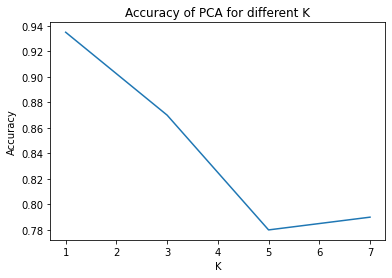

In [ ]:
k_list = [1, 3, 5, 7]
acc = tune_knn(k_list, "pca", train_matrix, train_label, test_matrix, test_label)
plt.plot(k_list, acc)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy of PCA for different K")
print()
plt.show()

Calculating U...
[1] Partitioning  Dataset into class-specific subsets:
[2] Computing Mean Vector for each class:
[[ 49.6  37.4 102.4 ... 106.8  84.  123.6]
 [ 52.   35.2 105.2 ... 108.8  86.6 124.2]
 [ 52.8  36.4 104.6 ... 107.8  84.4 124. ]
 ...
 [ 38.6  96.8  47.8 ...  72.  119.4  68. ]
 [ 40.  100.2  48.2 ...  65.  121.   68.6]
 [ 38.6  94.8  49.  ...  61.6 121.4  65.6]]
[3] Computing between-class scatter matrix:
[4] Centering Dataset:
[5] Computing the within-class scatter matrix:
[6] Solving for the eigenvectors:
(10304, 39)
Shape of U: (10304, 39)
K = 1	Accuracy = 0.925
K = 3	Accuracy = 0.855
K = 5	Accuracy = 0.785
K = 7	Accuracy = 0.77



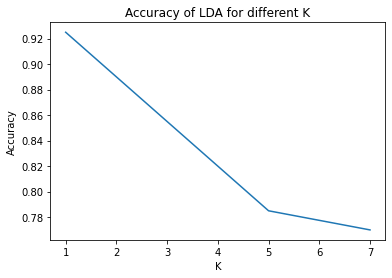

In [ ]:
k_list = [1, 3, 5, 7]
acc = tune_knn(k_list, "lda", train_matrix, train_label, test_matrix, test_label)
plt.plot(k_list, acc)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy of LDA for different K")
print()
plt.show()